# NEURAL NETWORKS AND DEEP LEARNING PROJECT

---
A.A. 2023/24 (6 CFU) - Giuseppe Labate, Sana Amiri
---

## Project 1 - Car classification, attribute prediction and car verification

In this project 

1.   **Classification** car images given cars dataset CompCars.

2.   **Attributes prediction** based on the images.  
        Attributes for this project are:  
    1. Explicit Attributes:  
    	1. Number of doors  
    	2. Number of seats  
    	3. Type of car  
	2. Implicit Attributes:  
    	4. Max speed  
    	5. Displacement  


In [1]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
# %matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
# sns.set()  ---> Uncomment if you want to use seaborn themes

## tqdm for loading bars
from tqdm.notebook import tqdm

## NumPy
import numpy as np
## PyTorch
import torch
import torch.nn as nnpo
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision   # For Computer Vision tasks
from torchvision import transforms   # Transforms for images for data augmentation


# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./Deep_Project"
TRAIN_TEST_SPLIT_PATH = DATASET_PATH + "/train_test_split"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = 0 #os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

C:\Users\giuse\AppData\Local\Temp\ipykernel_38704\3037075973.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: cuda:0
Number of workers: 0


<Figure size 640x480 with 0 Axes>

In [ ]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

# Carica un modello pre-addestrato su ImageNet
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Metti il modello in modalità di valutazione
model.eval()

In the following cell, I will create a transformation composition that will be applied to the images in our dataset. This transformation is crucial for preprocessing the images before they are fed into our machine learning model. The preprocessing steps may include operations such as resizing, normalization, augmentation, and other techniques to enhance the quality and variability of the training data. By applying these transformations, we aim to improve the model's performance and generalization capabilities. Let's proceed with defining this transformation function in the next cell.

In [ ]:
transform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In the next code snippet, we will perform DataLoading of the dataset contained in `./datasets`. The dataset will be split according to the splitting files located in the `train_test_split` folder.

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CarDataset(Dataset):
    def __init__(self, image_dir, label_dir, file_list, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Carica i percorsi delle immagini e le etichette dai file di testo
        with open(file_list, 'r') as f:
            for line in f:
                image_path = os.path.join(image_dir, line.strip())
                label_path = os.path.join(label_dir, line.strip()).replace('.jpg', '.txt')
                self.image_paths.append(image_path)
                self.labels.append((label_path, self._load_label(label_path)))

    def _load_label(self, label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            viewpoint = int(lines[0].strip())
            bbox = list(map(int, lines[2].strip().split()))
        return viewpoint, bbox

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")
        label_path, (viewpoint, bbox) = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, viewpoint, bbox, label_path

    def __len__(self):
        return len(self.image_paths)


# Percorsi delle directory delle immagini e delle etichette
image_dir = DATASET_PATH + "/image"
label_dir = DATASET_PATH + "/label"
train_list = DATASET_PATH + "train_test_split/classification/train.txt"
test_list = DATASET_PATH + "train_test_split/classification/test.txt"

# Crea i dataset
train_dataset = CarDataset(image_dir=image_dir, label_dir=label_dir, file_list=train_list, transform=transform)
test_dataset = CarDataset(image_dir=image_dir, label_dir=label_dir, file_list=test_list, transform=transform)

# Crea i data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Data loading is complete.")

In [ ]:
# Since the first task is classification, let's set the classification mode
mode = "classification"

# Load the dataset
train_dataset =  CarDataset(TRAIN_TEST_SPLIT_PATH + mode, "train", transform)
test_dataset =  CarDataset(TRAIN_TEST_SPLIT_PATH + mode, "test", transforms.ToTensor())

#valid_dataset needs to be created

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Load the dataset
dataset = ImageFolder(root=DATASET_PATH, transform=transform)

# Define the train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

print("Data loading is complete.")

Data loading is complete.


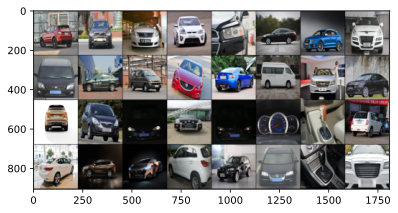

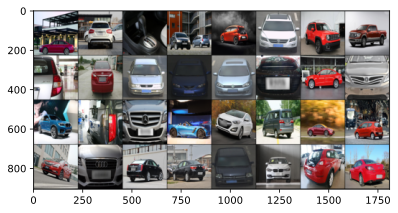

Number of training images: 167060
Number of test images: 41765


In [ ]:
#stampa alcune immagini da training set e test set
def imshow(img):
	img = img / 2 + 0.5  # unnormalize
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print the total number of images in both sets
print(f"Number of training images: {len(train_loader.dataset)}")
print(f"Number of test images: {len(test_loader.dataset)}")

In [ ]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
# %matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
# sns.set()  ---> Uncomment if you want to use seaborn themes

## tqdm for loading bars
from tqdm.notebook import tqdm

## NumPy
import numpy as np
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


NUM_WORKERS = 0 #os.cpu_count()
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

C:\Users\giuse\AppData\Local\Temp\ipykernel_11884\1439111186.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: cuda:0


<Figure size 640x480 with 0 Axes>

In [ ]:
from google.colab import drive
import zipfile
import os

# Monta Google Drive
drive.mount('/content/drive')

# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = "/content/drive/My Drive/datasets"
# Path to the ZIP file in Google Drive
dataset_zip_path = os.path.join(DATASET_PATH, "data.zip")
# Path to extract the dataset
dataset_extract_path = os.path.join(DATASET_PATH, "data")
# Password for the ZIP file
zip_password = b"d89551fd190e38"

# Create the dataset directory if it doesn't exist
os.makedirs(DATASET_PATH, exist_ok=True)

# Extract the dataset
if not os.path.exists(dataset_extract_path):
    print(f"Extracting dataset to {dataset_extract_path}...")
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_extract_path, pwd=zip_password)

print("Dataset is ready.")

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Extracting dataset to ./datasets\data2...


BadZipFile: zipfiles that span multiple disks are not supported